In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.copy_on_write = True

# Loading data

In [38]:
df = pd.read_csv('customer.csv')

# Exploratory Data Analysis and Preprocessing

Here we conduct a initial analysis of the dataset:

In [39]:
print("Seeing the first 10 lines of the dataset: \n")
print(df.head(10))
print('\n')
print("Counting the missing values in each column: \n")
print(df.isnull().sum())
print('\n')
print("Dataset info: \n")
print(df.info())
print("\n")
print("Number of rows:", len(df))
print("Number of columns:", len(df.columns))
print("\n")
print(df.describe())

Seeing the first 10 lines of the dataset: 

   Unnamed: 0        custid     sex is_employed   income      marital_status  \
0           7  000006646_03    Male        True  22000.0       Never married   
1           8  000007827_01  Female         NaN  23200.0  Divorced/Separated   
2           9  000008359_04  Female        True  21000.0       Never married   
3          10  000008529_01  Female         NaN  37770.0             Widowed   
4          11  000008744_02    Male        True  39000.0  Divorced/Separated   
5          15  000011466_01    Male         NaN  11100.0             Married   
6          17  000015018_01  Female        True  25800.0             Married   
7          19  000017314_02  Female         NaN  34600.0             Married   
8          20  000017383_04  Female        True  25000.0       Never married   
9          21  000017554_02    Male        True  31200.0             Married   

   health_ins                  housing_type  num_vehicles  age state_of_res

There are some null values in some columns that appear to be null for the same rows. In that case, dropping the rows could be a reasonable solution, if it doesn't cause a significant data loss.

In [40]:
n_null = len(df.loc[(df["housing_type"].isnull() == True) & (df["num_vehicles"].isnull() == True) 
                    & (df["gas_usage"].isnull() == True) & (df["recent_move_b"].isnull() == True)])
print(n_null)

1686


In [41]:
print(f"Percentage of data to be dropped: {(n_null / len(df)) * 100:.2f}%")

Percentage of data to be dropped: 2.33%


Since the rows are the same and it's just a 2% data loss, we decided to drop these rows.

In [42]:
df = df.dropna(subset=["housing_type"])

# checking if dropping worked
print(len(df[df["housing_type"].isnull() == True])) 
df[df["recent_move_b"].isnull() == True]

0


,Unnamed: 0,custid,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,code_column,gas_usage,rooms,recent_move_b
10030,14009,001148287_01,Female,False,5000.0,Married,True,Homeowner with mortgage/loan,0.0,42,California,8962,3.0,4,NaN


There was still one missing value in the column recent_move_b so we replaced it with the mode:

In [43]:
mode = df["recent_move_b"].mode()[0]
df["recent_move_b"] = df["recent_move_b"].fillna(mode)
print(len(df[df["recent_move_b"].isnull() == True]))

0


Now we take a look at the unique values inside each column, to know which ones are categorical and which and how many categories are there.

In [44]:
for col in df.columns:
    print(col)
    print(df[col].unique())
    print(len(df[col].unique()))
    print("\n")

Unnamed: 0
[    7     8     9 ... 99997 99998 99999]
70772


custid
['000006646_03' '000007827_01' '000008359_04' ... '001507219_01'
 '001513103_01' '001519624_01']
70772


sex
['Male' 'Female']
2


is_employed
[True nan False]
3


income
[22000. 23200. 21000. ... 25110. 18010. 26850.]
4423


marital_status
['Never married' 'Divorced/Separated' 'Widowed' 'Married']
4


health_ins
[ True False]
2


housing_type
['Homeowner free and clear' 'Rented' 'Homeowner with mortgage/loan'
 'Occupied with no rent']
4


num_vehicles
[0. 2. 1. 5. 3. 4. 6.]
7


age
[ 24  82  31  93  67  76  26  73  27  54  61  64  55  65  33  47  68  46
  58  43  41  62  21  78  32  59  29  70  30  28  86  35  34  40  72  60
  25  79  22  42  44  81  50  45  63  57  39  71  38  49  69  37  66  53
  36  23  75  88  51  85  52  83  77  56  48 100  74  89  80  84   0  87
 120  91 110 114  94  90  96  92  95]
81


state_of_res
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Dist

We can see unnamed and custid columns have unique values, which won't be usefull for predictions. Also, we can see all numeric values are integers, and the one with more variability is income, which is expected.

Also we can see there are "nan" values on the is_employed column, which actually represent not in workforce, as said in the data dictionary. Thus, we have to be carefull to not treat the "nan" values as null values, but as a category.

Now, we can take a look on the age distribution to determine if the customers are mostly young, middle-aged or seniors.

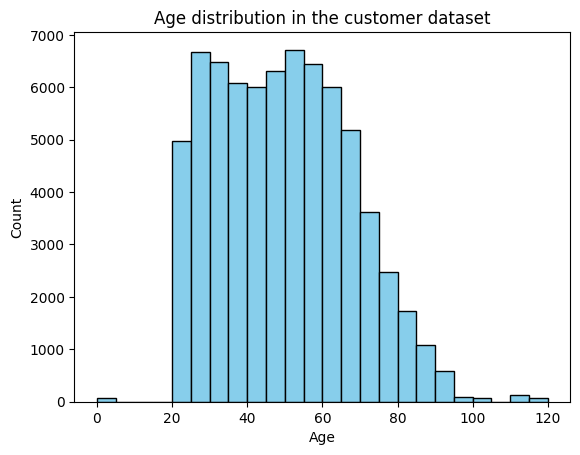

In [45]:
plt.hist(df["age"], bins=24, edgecolor='black', color='skyblue')
plt.title("Age distribution in the customer dataset")
plt.ylabel("Count")
plt.xlabel("Age")
plt.show()

The histogram shows there are mostly young adults and middle-aged customers. Each bin contains a 5 year interval. There are also potential errors/outliers (values near 120).

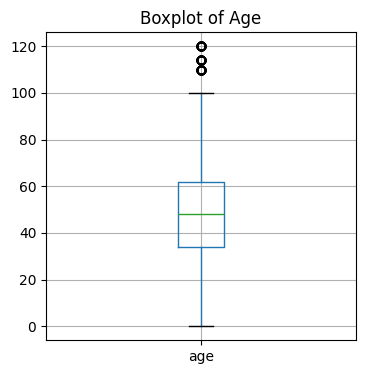

In [46]:
df.boxplot(column="age", figsize=(4,4))
plt.title('Boxplot of Age')
plt.show()

There are indeed some outliers that need to be addressed.

Now, we take a look at the income:

In [47]:
df["income"].describe()

count    7.077200e+04
mean     4.263163e+04
std      5.864181e+04
min     -6.900000e+03
25%      1.130000e+04
50%      2.748500e+04
75%      5.205500e+04
max      1.257000e+06
Name: income, dtype: float64

**Note**: Negative values represent loss.

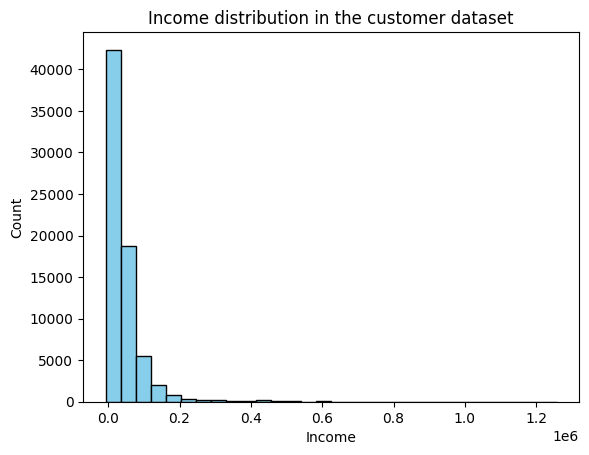

In [48]:
plt.hist(df["income"], edgecolor='black', color='skyblue', bins=30)
plt.title("Income distribution in the customer dataset")
plt.ylabel("Count")
plt.xlabel("Income")
plt.show()

It's highly right-skewed, which is expected for this variable. Now we can take a look at the boxplot:

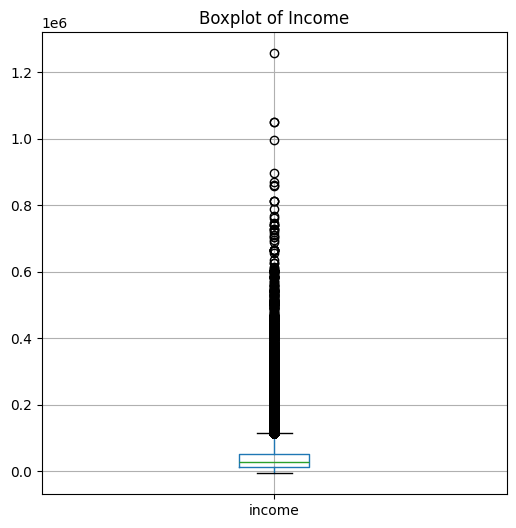

In [49]:
df.boxplot(column="income", figsize=(6,6))
plt.title('Boxplot of Income')
plt.show()

It shows a high number of outliers because of it's high concentration near the lower values (not a normal distribution).

In [50]:
print("Skewness:", df["income"].skew())
print("Kurtosis:", df["income"].kurtosis())

Skewness: 4.851249584109513
Kurtosis: 37.56168753204299


Left-skewness and very high kurtosis indicate transformations are needed before modeling.

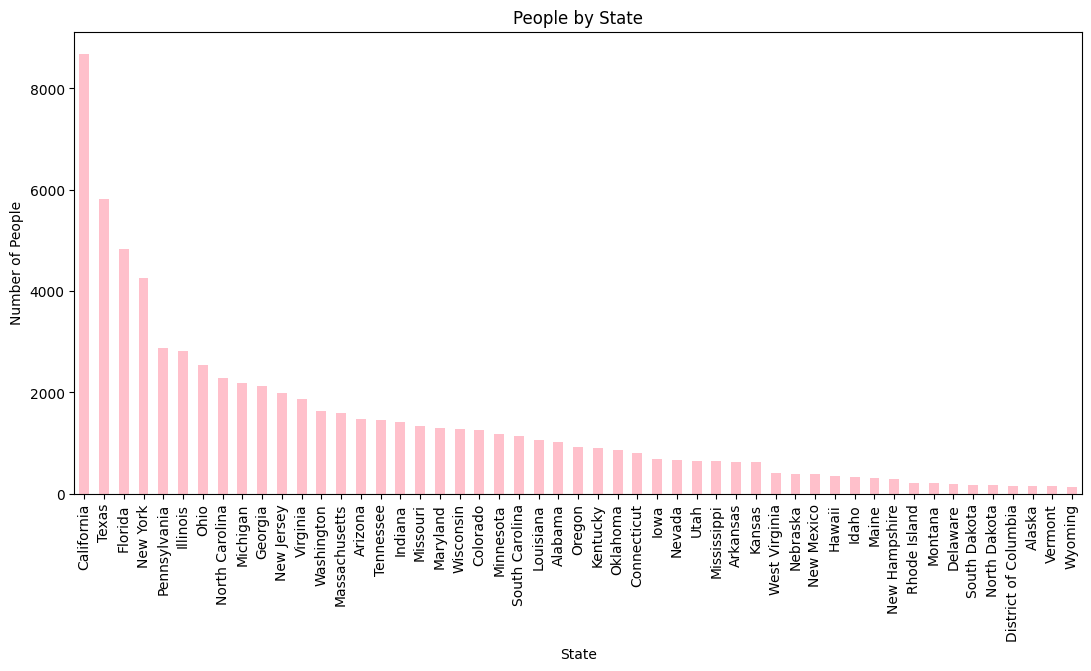

In [51]:
# Where do they live?

state_counts = df['state_of_res'].value_counts()
plt.figure(figsize=(13, 6))
state_counts.plot(kind='bar', color='pink')
plt.title('People by State')
plt.xlabel('State')
plt.ylabel('Number of People')
plt.show()

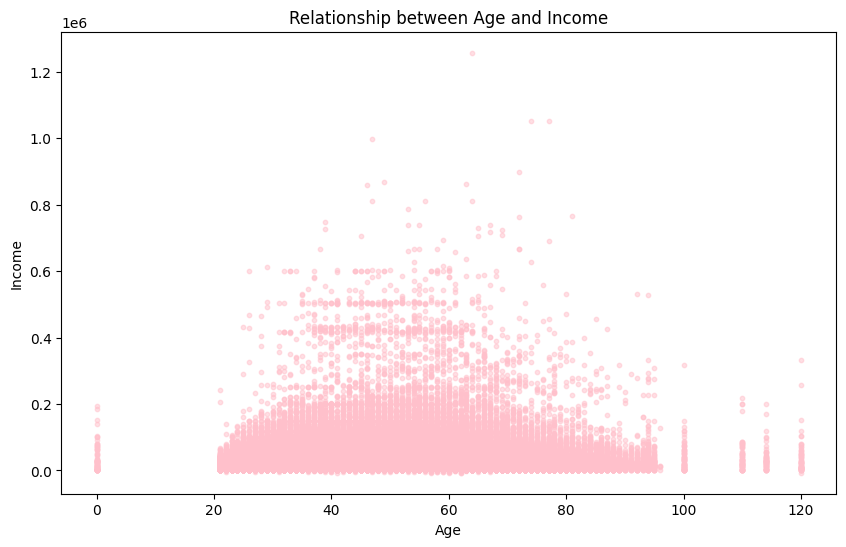

In [52]:
# What is the relation between age and income?

plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['income'], alpha=0.5, s=10, color='pink')  
plt.title('Relationship between Age and Income')
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()

(Como se pode ver no gráfico, há claros outliers na idade mas fora isso vemos que o income tem o seu peak na middle age (30-60) e mais baixos em pessoas mais velhas e mais novas que esse intervalo)

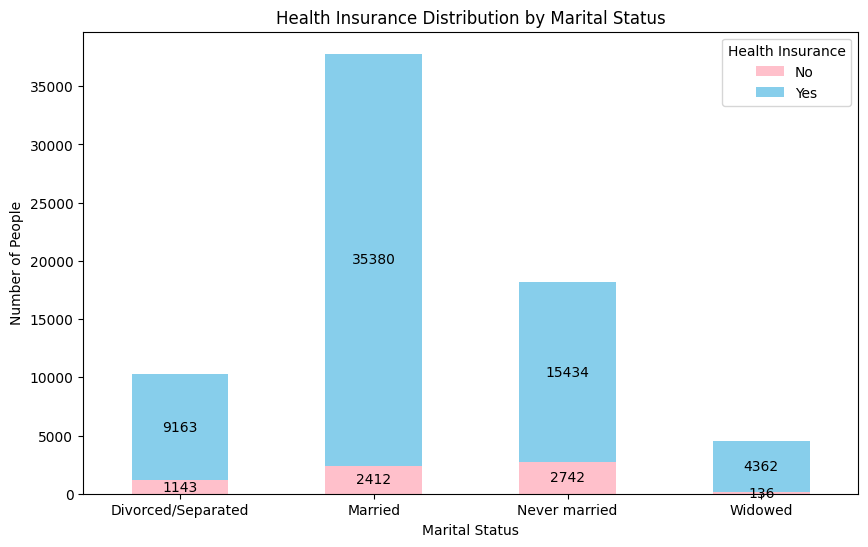

health_ins              False      True 
marital_status                          
Divorced/Separated  11.090627  88.909373
Married              6.382303  93.617697
Never married       15.085827  84.914173
Widowed              3.023566  96.976434


In [53]:
#How the health insurance distributes according to the marital status?

health_counts = df.groupby(['marital_status', 'health_ins']).size().unstack()
ax = health_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['pink', 'skyblue'])

# Add labels to each bar segment
for container in ax.containers:
    ax.bar_label(container, label_type='center')  

# Customize plot
plt.title('Health Insurance Distribution by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Number of People')
plt.legend(title='Health Insurance', labels=['No', 'Yes'])  
plt.xticks(rotation=0)  
plt.show()

# Percentages

print(health_counts.div(health_counts.sum(axis=1), axis=0) * 100)

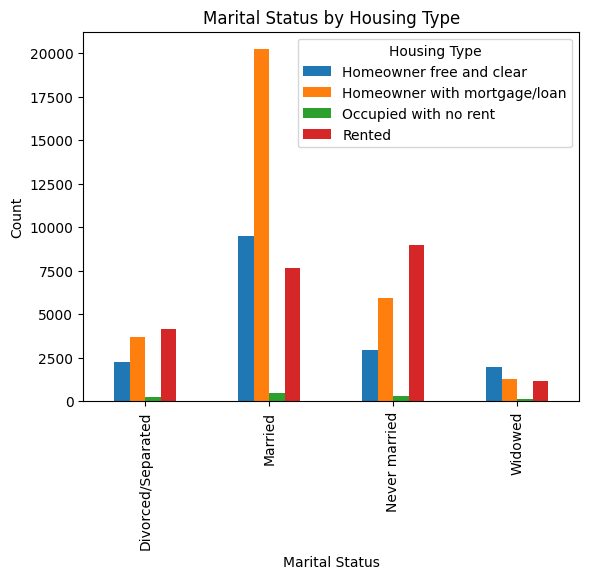

In [54]:
#Visualize the marital status according to the housing type 

marital_housing_counts = pd.crosstab(df['marital_status'], df['housing_type'])
marital_housing_counts.plot(kind='bar', stacked=False)
plt.title("Marital Status by Housing Type")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.legend(title="Housing Type")
plt.show()

             count          mean           std     min      25%      50%  \
age_group                                                                  
<25         6325.0  17870.236838  19152.237581 -5800.0   4300.0  13500.0   
25-34      13105.0  36652.213659  40669.306471 -5500.0  12000.0  29900.0   
35-49      18408.0  51488.357616  66424.568997 -6700.0  14200.0  35000.0   
50-64      18944.0  50419.020323  68862.305690 -6800.0  12000.0  32000.0   
65+        13727.0  37185.322066  54261.527828 -5500.0  11900.0  22000.0   

               75%        max  
age_group                      
<25        25000.0   433000.0  
25-34      50000.0   611000.0  
35-49      65000.0   997000.0  
50-64      62200.0  1257000.0  
65+        42300.0  1051000.0  
          count          mean           std     min      25%      50%  \
sex                                                                     
Female  36896.0  31658.612289  40588.002240 -6800.0   8600.0  20500.0   
Male    33876.0  54582.8

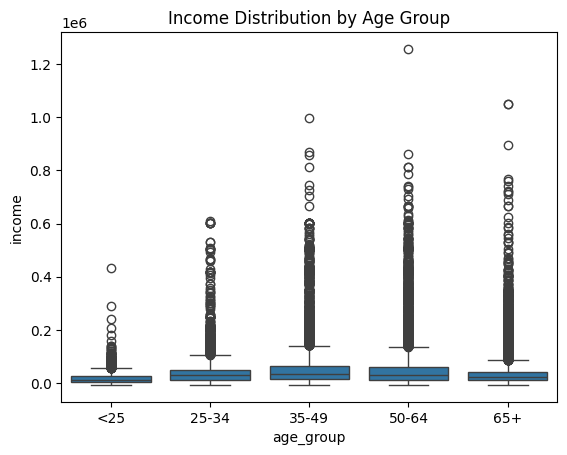

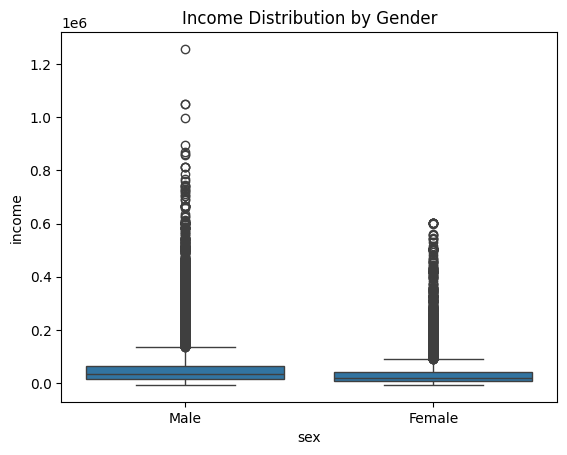

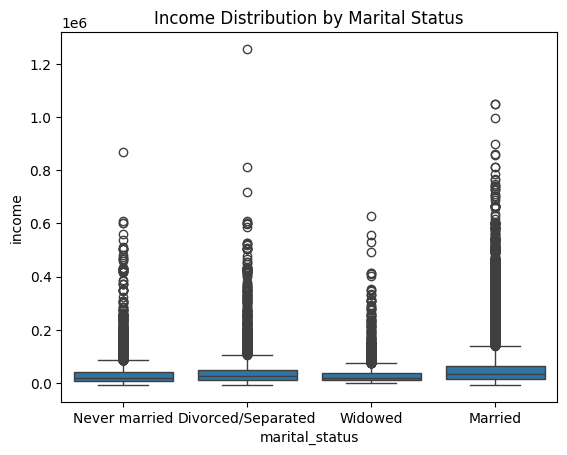

In [55]:
# Do you see differences in the income related to age, gender or the marital situation?

# Comparing incomes: 
# Income statistics by age
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 50, 65, 100], labels=['<25', '25-34', '35-49', '50-64', '65+'])
print(df.groupby('age_group', observed=True)['income'].describe())

# Income statistics by gender
print(df.groupby('sex')['income'].describe())

# Income statistics by marital status
print(df.groupby('marital_status')['income'].describe())

# Visualizing income differences:
# Income vs. Age
sns.boxplot(x='age_group', y='income', data=df)
plt.title("Income Distribution by Age Group")
plt.show()

# clean new column
df = df.drop(columns=["age_group"])

# Income vs. Gender
sns.boxplot(x='sex', y='income', data=df)
plt.title("Income Distribution by Gender")
plt.show()

# Income vs. Marital Status
sns.boxplot(x='marital_status', y='income', data=df)
plt.title("Income Distribution by Marital Status")
plt.show()

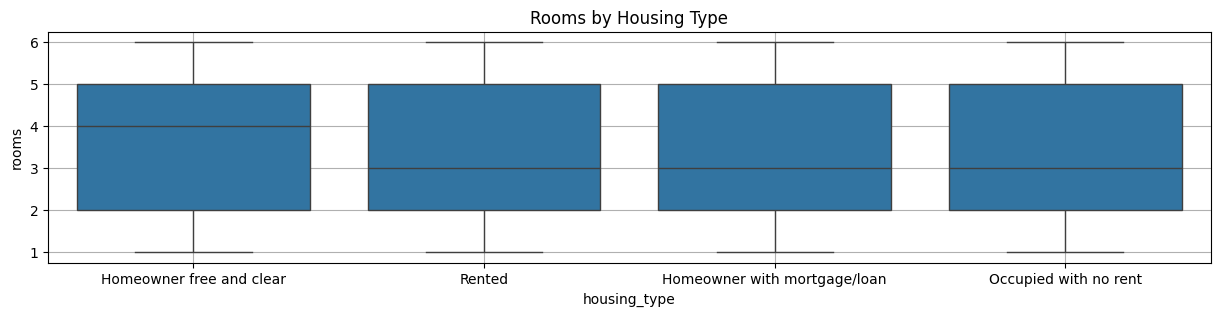

In [56]:
# Rooms by Housing Type
plt.figure(figsize=(15, 3))
sns.boxplot(x='housing_type', y='rooms', data=df)
plt.title("Rooms by Housing Type")
plt.grid()
plt.show()

Owned houses have more rooms (median is 4) than the others (median 3).

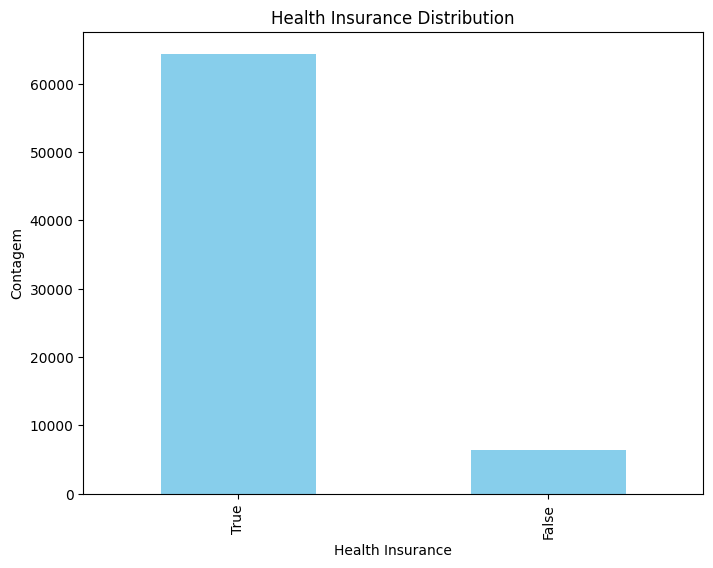

health_ins
True     64339
False     6433
Name: count, dtype: int64


In [57]:
health_ins_distribution = df['health_ins'].value_counts()

plt.figure(figsize=(8, 6))
health_ins_distribution.plot(kind='bar', color='skyblue')
plt.title('Health Insurance Distribution')
plt.xlabel('Health Insurance')
plt.ylabel('Contagem')
plt.show()

print(health_ins_distribution)

### Dropping and One-hot encoding

In [58]:
# Drop unnamed
df = df.drop(columns=['Unnamed: 0'])

# Drop custid and code_column
df = df.drop(columns=['custid', 'code_column'])
# code_column corresponds to state

df['is_employed'] = df['is_employed'].map({False: "unemployed", True: "employed"})
df['is_employed'] = df['is_employed'].fillna("not_in_workforce")

df['num_vehicles'] = df['num_vehicles'].astype(int)

df['gas_usage'] = df['gas_usage'].astype(int)
df['gas_usage'] = df['gas_usage'].replace([1, 2, 3], 0)

In [59]:
def encoding(df):
    df = pd.get_dummies(df, columns=['sex'], drop_first=True)

    df['recent_move_b'] = df['recent_move_b'].map({'F': 0, 'T': 1})

    # One-hot encoding
    df = pd.get_dummies(df, columns=['marital_status'], drop_first=True)
    df = pd.get_dummies(df, columns=['housing_type'], drop_first=True)
    df = pd.get_dummies(df, columns=['state_of_res'], drop_first=True)
    df = pd.get_dummies(df, columns=['is_employed'], drop_first=True)

    df = df.replace({True: 1, False: 0}).infer_objects(copy=False)
    
    return df

C:\Users\PC\AppData\Local\Temp\ipykernel_7852\110884052.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0}).infer_objects(copy=False)


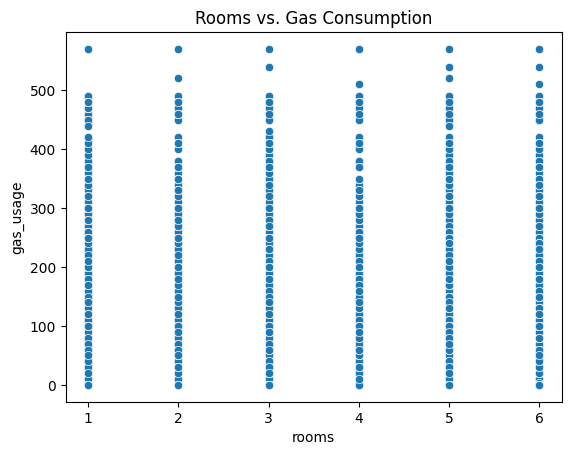

,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,gas_usage,rooms
housing_type_Homeowner with mortgage/loan,1.000000,-0.112249,-0.593655,0.116857,-0.003992
housing_type_Occupied with no rent,-0.112249,1.000000,-0.085043,-0.008072,-0.000834
housing_type_Rented,-0.593655,-0.085043,1.000000,-0.165388,0.000079
gas_usage,0.116857,-0.008072,-0.165388,1.000000,0.001158
rooms,-0.003992,-0.000834,0.000079,0.001158,1.000000


In [60]:
#Are the characteristics of the housing situation interrelated 
#(e.g. is the number of rooms related to the housing type or gas consumption?)

# Visualizing relationships:
dfc= encoding(df)

sns.scatterplot(x='rooms', y='gas_usage', data=dfc)
plt.title("Rooms vs. Gas Consumption")
plt.show()

# Checking correlations:
housing_corr = dfc[['housing_type_Homeowner with mortgage/loan', 'housing_type_Occupied with no rent', 'housing_type_Rented', 'gas_usage', "rooms"]].corr()
housing_corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)


Room is not correlated at all and gas_usage is just a bit with occupied with no rent and rented (less than 0.2).

Since gas_usage is also a numeric column, it's important to check if it is normally distributed or skewed before modeling.

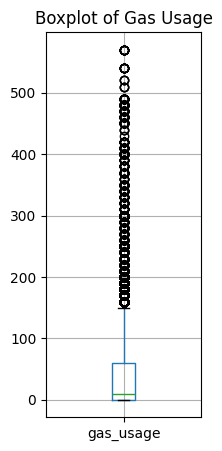

In [61]:
df.boxplot(column="gas_usage", figsize=(2,5))
plt.title('Boxplot of Gas Usage')
plt.show()

The boxplot shows it is skewed and needs handling.

### Data transformation

As it was seen, income and gas_usage are highly skewed and age has some unusual values that need to be handled. Therefore, we apply a logarithmic transformation to the first two and remove the outliers from the first one, since they're most likely wrong values.

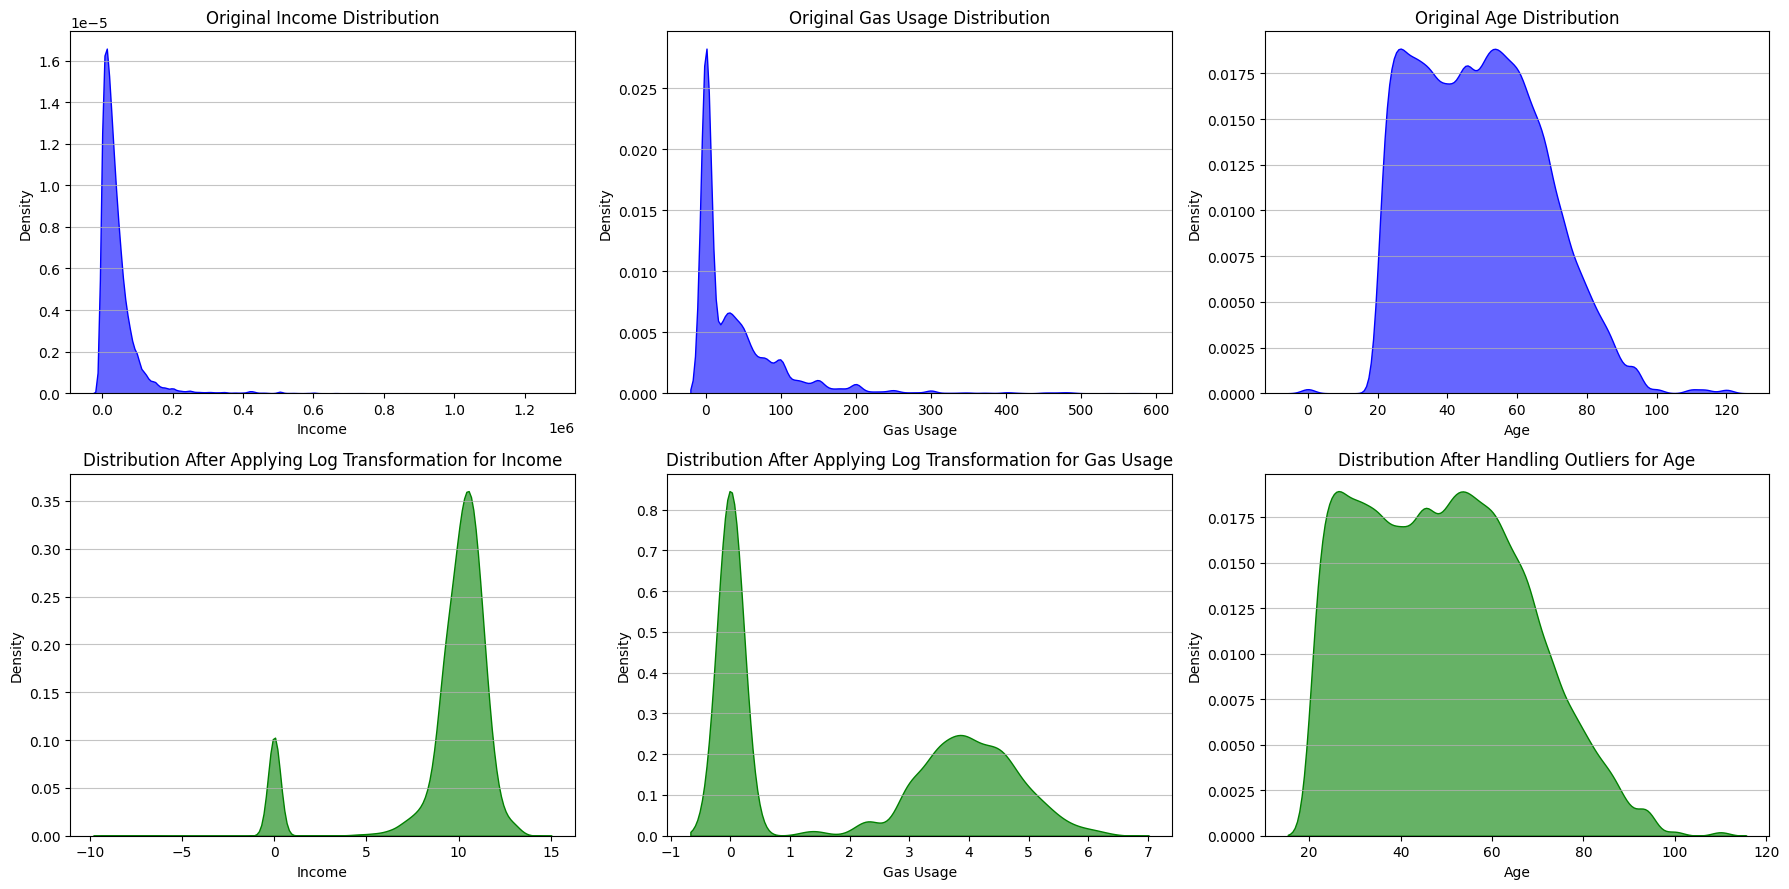

In [62]:
plt.figure(figsize=(18, 9))  

# Before (subplots 1, 2, 3)

plt.subplot(2, 3, 1)
sns.kdeplot(df['income'], fill=True, color='blue', alpha=0.6)
plt.title('Original Income Distribution')
plt.xlabel('Income')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 3, 2)
sns.kdeplot(df['gas_usage'], fill=True, color='blue', alpha=0.6)
plt.title('Original Gas Usage Distribution')
plt.xlabel('Gas Usage')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 3, 3)
sns.kdeplot(df['age'], fill=True, color='blue', alpha=0.6)
plt.title('Original Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

# Handling outliers for income, age, and gas usage
df['income'] = df['income'].apply(
    lambda x: np.log(x) if x > 0 else (-np.log(abs(x)) if x < 0 else 0)
)
#df['income'] = df['income'].where(df['income'] <= 0.1 * 10**6, 0.1 * 10**6)
df = df[(df['age'] != 0) & (df['age'] <= 110)]
df['gas_usage'] = df['gas_usage'].apply(lambda x: np.log(x) if x > 0 else 0)

# After handling outliers (subplots 4, 5, 6)

plt.subplot(2, 3, 4)
sns.kdeplot(df['income'], fill=True, color='green', alpha=0.6)
plt.title('Distribution After Applying Log Transformation for Income')
plt.xlabel('Income')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 3, 5)
sns.kdeplot(df['gas_usage'], fill=True, color='green', alpha=0.6)
plt.title('Distribution After Applying Log Transformation for Gas Usage')
plt.xlabel('Gas Usage')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 3, 6)
sns.kdeplot(df['age'], fill=True, color='green', alpha=0.6)
plt.title('Distribution After Handling Outliers for Age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()  
plt.show()


After removing age outliers, would be interisting to visualize the probability of health insurance by age:

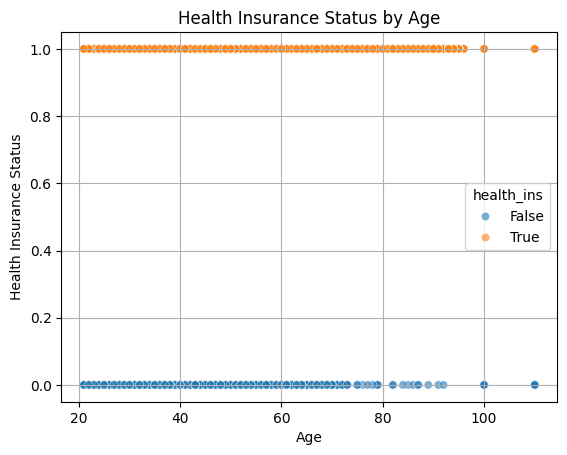

In [63]:
sns.scatterplot(x='age', y='health_ins', data=df, alpha=0.6, hue="health_ins")
plt.xlabel('Age')
plt.ylabel('Health Insurance Status')
plt.title('Health Insurance Status by Age')
plt.grid()
plt.show()

The graph shows there isn't a clear relationship for age and health insurance status, except for a small difference on the older ages where there seem to be more people with insurance than with not.

Now, after applying data transformations, let's encode all the categorical variables again and then create the correlation matrix:

In [64]:
dfc = encoding(df)
correlation_matrix = dfc.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

C:\Users\PC\AppData\Local\Temp\ipykernel_7852\110884052.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0}).infer_objects(copy=False)


,income,health_ins,num_vehicles,age,gas_usage,rooms,recent_move_b,sex_Male,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,state_of_res_Alaska,state_of_res_Arizona,state_of_res_Arkansas,state_of_res_California,state_of_res_Colorado,state_of_res_Connecticut,state_of_res_Delaware,state_of_res_District of Columbia,state_of_res_Florida,state_of_res_Georgia,state_of_res_Hawaii,state_of_res_Idaho,state_of_res_Illinois,state_of_res_Indiana,state_of_res_Iowa,state_of_res_Kansas,state_of_res_Kentucky,state_of_res_Louisiana,state_of_res_Maine,state_of_res_Maryland,state_of_res_Massachusetts,state_of_res_Michigan,state_of_res_Minnesota,state_of_res_Mississippi,state_of_res_Missouri,state_of_res_Montana,state_of_res_Nebraska,state_of_res_Nevada,state_of_res_New Hampshire,state_of_res_New Jersey,state_of_res_New Mexico,state_of_res_New York,state_of_res_North Carolina,state_of_res_North Dakota,state_of_res_Ohio,state_of_res_Oklahoma,state_of_res_Oregon,state_of_res_Pennsylvania,state_of_res_Rhode Island,state_of_res_South Carolina,state_of_res_South Dakota,state_of_res_Tennessee,state_of_res_Texas,state_of_res_Utah,state_of_res_Vermont,state_of_res_Virginia,state_of_res_Washington,state_of_res_West Virginia,state_of_res_Wisconsin,state_of_res_Wyoming,is_employed_not_in_workforce,is_employed_unemployed
income,1.000000,0.174906,0.037929,0.093140,0.022208,0.000498,-0.013026,0.177992,0.029309,-0.072964,0.015793,0.083537,-0.035596,-0.076428,0.002975,-0.007729,-0.009087,-0.024223,0.015662,0.014436,-0.000822,0.006537,-0.019333,-0.011486,0.005887,-0.002392,-0.000800,0.005127,0.012725,0.007589,-0.003770,-0.013444,0.007560,0.016626,0.023693,0.000875,0.019883,-0.008593,0.006755,0.007538,0.008458,-0.002510,0.012253,0.007035,-0.009662,-0.001970,-0.007338,0.006812,0.003469,-0.005283,-0.002801,0.014913,0.007283,-0.006197,0.005735,-0.001845,-0.018511,-0.002573,0.012562,0.010958,0.007434,0.001657,0.017688,0.005601,-0.439849,-0.155837
health_ins,0.174906,1.000000,0.036366,0.168379,0.054463,-0.006142,-0.058678,-0.047102,0.100770,-0.122682,0.055048,0.107671,-0.030076,-0.148064,-0.017662,-0.000266,0.003776,0.012700,0.006542,0.016339,0.003429,0.007893,-0.039245,-0.031562,0.017025,-0.002507,0.014586,-0.000080,0.015558,0.001787,0.011217,-0.012463,0.002570,0.011549,0.032188,0.024873,0.022053,-0.012078,-0.001789,0.001976,-0.006795,-0.006338,0.004451,0.008177,-0.001267,0.021730,-0.022668,0.004873,0.019087,-0.016525,0.006300,0.024146,0.010273,-0.008415,-0.005711,-0.003141,-0.081764,0.002366,0.009803,0.001415,0.013329,0.011407,0.019461,-0.004134,0.047542,-0.099778
num_vehicles,0.037929,0.036366,1.000000,-0.129318,0.119787,-0.001677,-0.119036,0.058573,0.215569,-0.051445,-0.145114,0.280994,-0.040431,-0.315048,0.005543,-0.001890,0.003455,0.063308,0.017578,-0.003990,0.004392,-0.040563,-0.033762,0.004392,0.018749,0.011663,-0.016818,0.006396,0.009967,0.019002,0.000856,-0.011044,0.002006,0.000128,-0.024556,-0.004427,0.009799,0.000685,0.001241,0.017490,0.007102,-0.004795,0.009989,-0.012825,0.009378,-0.129603,0.011286,0.003577,-0.003037,-0.000737,0.011589,-0.015169,-0.005143,0.006219,0.009673,0.014993,0.017555,0.029904,-0.003655,0.020455,0.017738,-0.006747,0.007728,0.006756,-0.163596,-0.024378
age,0.093140,0.168379,-0.129318,1.000000,0.044965,-0.002409,-0.214287,-0.041703,0.155183,-0.464590,0.365093,-0.035384,0.003305,-0.254506,-0.013551,0.005933,-0.001507,-0.027912,-0.008899,0.014231,0.006623,-0.009721,0.035785,-0.010632,0.004107,0.003433,-0.003906,-0.003705,0.011105,0.000867,0.005746,-0.007984,0.014146,0.002066,0.003603,0.006128,0.002492,0.005361,-0.001490,0.007563,-0.001159,-0.004110,0.008023,0.004373,0.001595,0.002458,-0.003114,-0.002751,0.009743,-0.001769,0.005130,0.012932,-0.000143,0.002304,0.006104,0.011740,-0.032534,-0.020884,0.007232,0.001024,-0.006754,0.010170,0.003067,-0.004139,0.468659,-0.098757
gas_usage,0.022208,0.054463,0.119787,0.044965,1.

From that we conclude there are no two features with high enough correlation with another to make us drop it.

Looking at the health_ins column we can decide to drop some features that show really low correlation, since they might not be very usefull for predicting the target variable.

In [65]:
dfc = dfc.drop(dfc.columns[dfc.columns.str.startswith('state')], axis=1)
dfc = dfc.drop(columns=["rooms"])
correlation_matrix = dfc.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,income,health_ins,num_vehicles,age,gas_usage,recent_move_b,sex_Male,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,is_employed_not_in_workforce,is_employed_unemployed
income,1.000000,0.174906,0.037929,0.093140,0.022208,-0.013026,0.177992,0.029309,-0.072964,0.015793,0.083537,-0.035596,-0.076428,-0.439849,-0.155837
health_ins,0.174906,1.000000,0.036366,0.168379,0.054463,-0.058678,-0.047102,0.100770,-0.122682,0.055048,0.107671,-0.030076,-0.148064,0.047542,-0.099778
num_vehicles,0.037929,0.036366,1.000000,-0.129318,0.119787,-0.119036,0.058573,0.215569,-0.051445,-0.145114,0.280994,-0.040431,-0.315048,-0.163596,-0.024378
age,0.093140,0.168379,-0.129318,1.000000,0.044965,-0.214287,-0.041703,0.155183,-0.464590,0.365093,-0.035384,0.003305,-0.254506,0.468659,-0.098757
gas_usage,0.022208,0.054463,0.119787,0.044965,1.000000,-0.089366,-0.003539,0.081730,-0.053624,-0.011291,0.149829,-0.022290,-0.210803,-0.006361,-0.012155
recent_move_b,-0.013026,-0.058678,-0.119036,-0.214287,-0.089366,1.000000,0.002796,-0.088147,0.113431,-0.049833,-0.159418,0.003635,0.308278,-0.078355,0.030624
sex_Male,0.177992,-0.047102,0.058573,-0.041703,-0.003539,0.002796,1.000000,0.046469,0.065634,-0.137087,0.013653,0.003472,-0.005824,-0.125052,0.013390
marital_status_Married,0.029309,0.100770,0.215569,0.155183,0.081730,-0.088147,0.046469,1.000000,-0.629490,-0.278652,0.206258,-0.028541,-0.250731,-0.005771,-0.072867
marital_status_Never married,-0.072964,-0.122682,-0.051445,-0.464590,-0.053624,0.113431,0.065634,-0.629490,1.000000,-0.153089,-0.134028,0.008944,0.234533,-0.142916,0.090203
marital_status_Widowed,0.015793,0.055048,-0.145114,0.365093,-0.011291,-0.049833,-0.137087,-0.278652,-0.153089,1.000000,-0.084229,0.014415,-0.027338,0.248863,-0.032417


### Data scaling

In [66]:
from sklearn import preprocessing

def scaling(df):
    scaler = preprocessing.StandardScaler()

    # Identificar colunas binárias (valores únicos {0, 1})
    binary_cols = [col for col in df.columns if set(df[col].unique()) == {0, 1}]
    continuous_cols = [col for col in df.columns if col not in binary_cols]

    # Escalar apenas as colunas contínuas
    df_scaled = df.copy()
    df_scaled[continuous_cols] = scaler.fit_transform(df[continuous_cols])
    
    # Colunas binárias permanecem inalteradas
    return df_scaled

Final dataset: (non-scaled)

In [67]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70573 entries, 0 to 72456
Data columns (total 15 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   income                                     70573 non-null  float64
 1   health_ins                                 70573 non-null  int64  
 2   num_vehicles                               70573 non-null  int64  
 3   age                                        70573 non-null  int64  
 4   gas_usage                                  70573 non-null  float64
 5   recent_move_b                              70573 non-null  int64  
 6   sex_Male                                   70573 non-null  int64  
 7   marital_status_Married                     70573 non-null  int64  
 8   marital_status_Never married               70573 non-null  int64  
 9   marital_status_Widowed                     70573 non-null  int64  
 10  housing_type_Homeowner with

# Modeling

Evaluation Function

In [68]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score,f1_score


def evaluation(y,y_pred):
    # Scores
    print("F1 score: ", f1_score(y, y_pred, pos_label=0))
    print("Precision: ", precision_score(y, y_pred, pos_label=0))
    print("Recall: ", recall_score(y, y_pred,pos_label=0))
    print("Accuracy: ", accuracy_score(y, y_pred))

    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
    # Confusion Matrix
    sns.heatmap(confusion_matrix(y, y_pred), 
            annot=True, fmt="d", cmap="Blues", cbar=False, square=True, ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    auc_score = roc_auc_score(y, y_pred)

    axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", color="blue")
    axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
    axes[1].set_title("Receiver Operating Characteristic (ROC) Curve")
    axes[1].set_xlabel("False Positive Rate (FPR)")
    axes[1].set_ylabel("True Positive Rate (TPR)")
    axes[1].legend(loc="lower right")
    axes[1].grid()

    plt.tight_layout()
    plt.show()

Scorer:

In [69]:
from sklearn.metrics import f1_score, make_scorer

f1_label_0 = make_scorer(f1_score, pos_label=0, average="binary")

### K-NN

In [70]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

dfknn= scaling(dfc)

y = dfknn["health_ins"]
X = dfknn.drop(["health_ins"], axis=1) 

Non-stratified:

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_grid = {'n_neighbors': range(1, 11)}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring=f1_label_0,
    cv=kf,  
    n_jobs=-1, 
)

grid_search.fit(X_train, y_train)

optimal_k = grid_search.best_params_['n_neighbors']
print(f"Optimal k: {optimal_k}")

y_pred = grid_search.best_estimator_.predict(X_test)

Optimal k: 2


F1 score:  0.2566694748666105
Precision:  0.20320142285460205
Recall:  0.3483231707317073
Accuracy:  0.8124690046050301


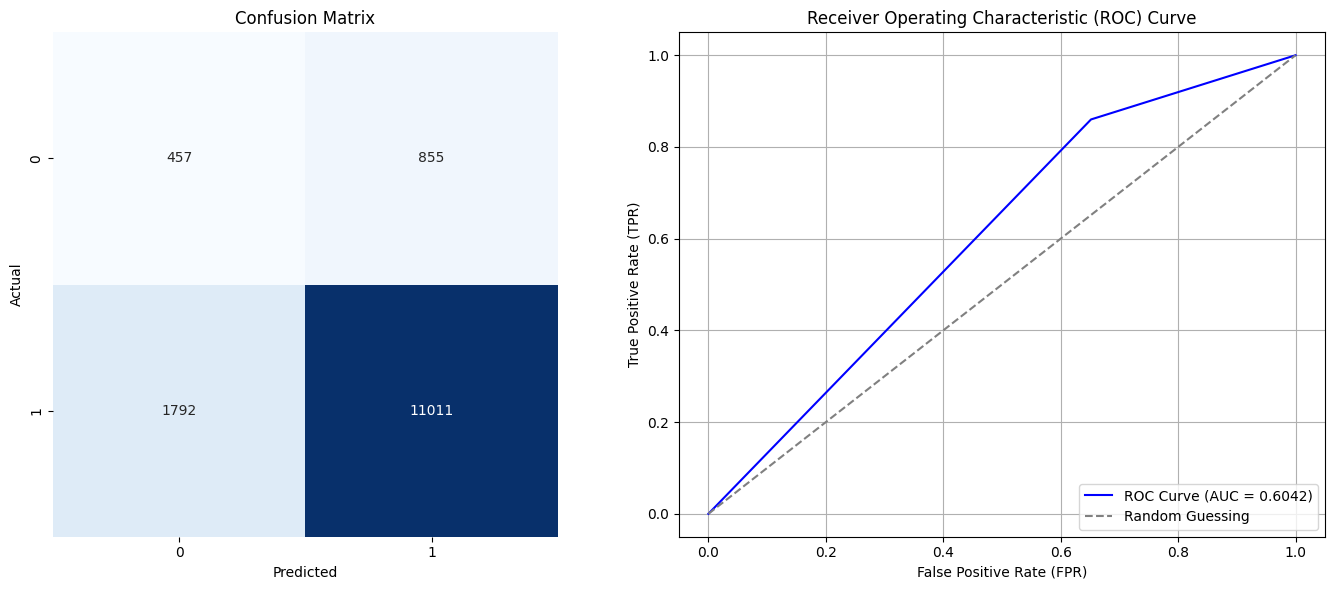

In [72]:
evaluation(y_test,y_pred)

Stratified:

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
param_grid = {'n_neighbors': range(1, 11)}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring=f1_label_0,
    cv=skf,  
    n_jobs=-1, 
)

grid_search.fit(X_train, y_train)

optimal_k = grid_search.best_params_['n_neighbors']
print(f"Optimal k: {optimal_k}")

y_pred = grid_search.best_estimator_.predict(X_test)

Optimal k: 2


F1 score:  0.24572230014025245
Precision:  0.19202104340201667
Recall:  0.3411214953271028
Accuracy:  0.8094934466879207


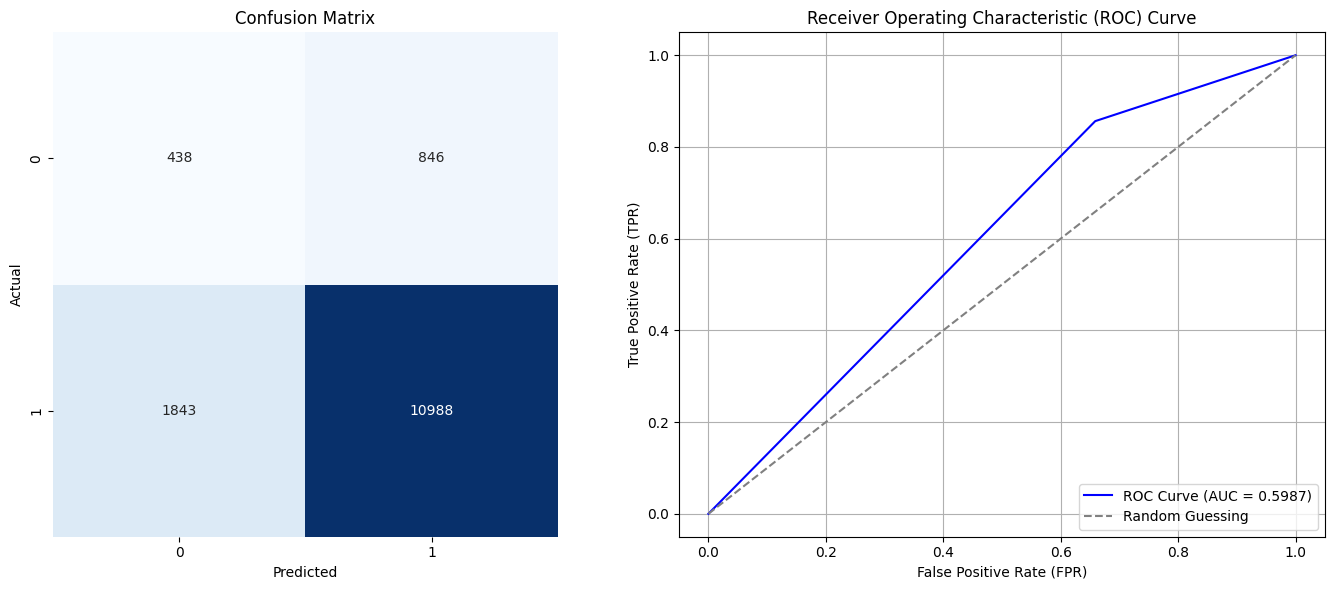

In [74]:
evaluation(y_test,y_pred)

### Predict with Bayesian Classifier


In [75]:
from sklearn.naive_bayes import GaussianNB

dfbc = dfknn
X = dfbc.drop('health_ins', axis=1)  
y = dfbc['health_ins'] 

Non-stratified

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gauss = GaussianNB()
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)

F1 score:  0.27370478983382207
Precision:  0.23904382470119523
Recall:  0.3201219512195122
Accuracy:  0.8420828905419766


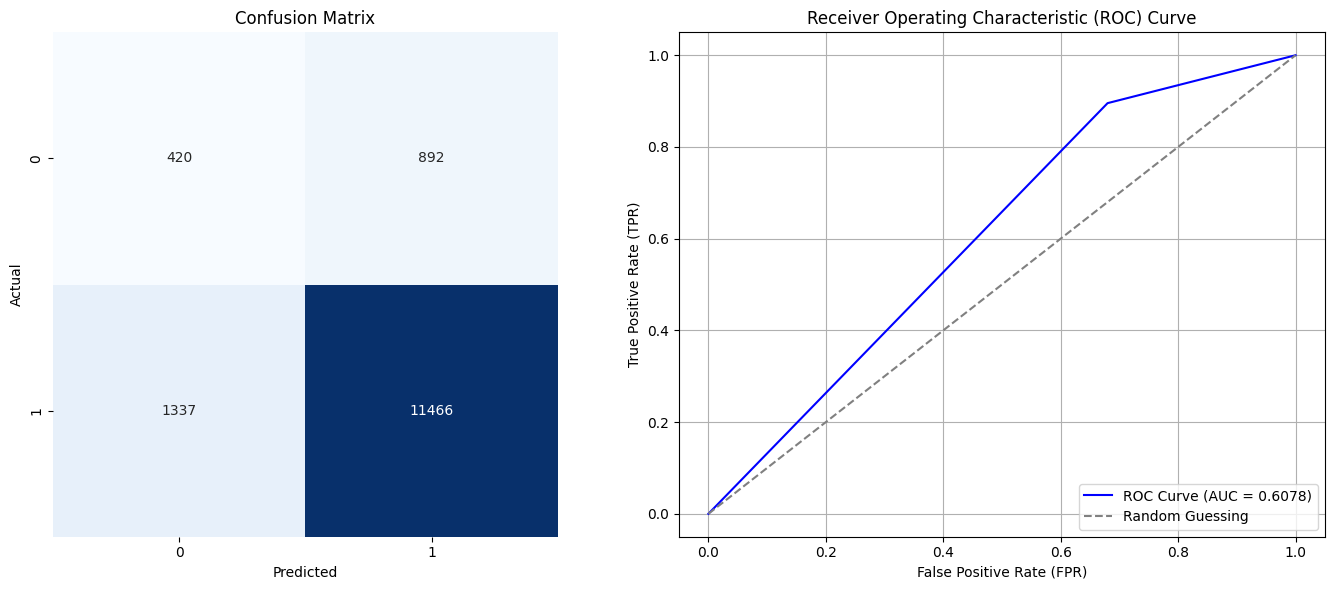

In [77]:
evaluation(y_test,y_pred)

Stratified

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

gauss = GaussianNB()
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)

F1 score:  0.2570792236716513
Precision:  0.21732114039806347
Recall:  0.3146417445482866
Accuracy:  0.834573149132129


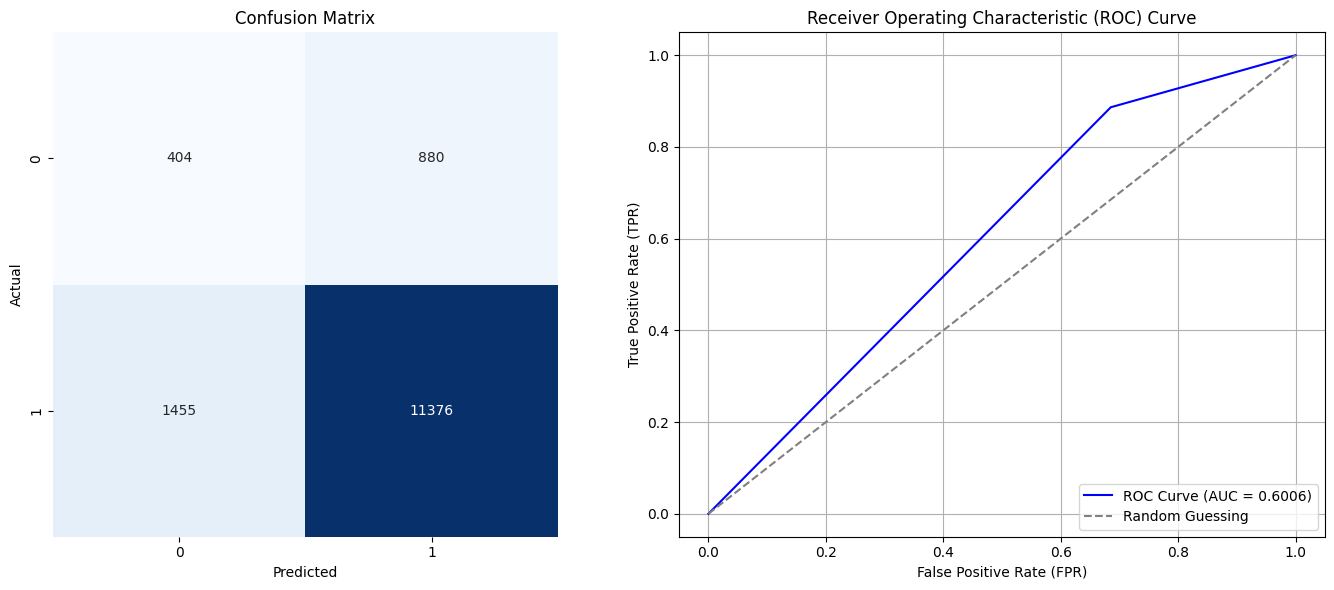

In [79]:
evaluation(y_test,y_pred)

### Decision Trees

In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve

dftree=dfc

X = dftree.drop('health_ins', axis=1)  
y = dftree['health_ins'] 

Non-Stratified

In [81]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {'max_depth': range(1, 20)}

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=kf, scoring=f1_label_0)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)
mean_f1_scores = grid_search.cv_results_['mean_test_score']
max_depth_values = grid_search.cv_results_['param_max_depth'].data

print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 9}


F1 score:  0.31449925261584455
Precision:  0.1956117515805132
Recall:  0.801829268292683
Accuracy:  0.6750974140984768


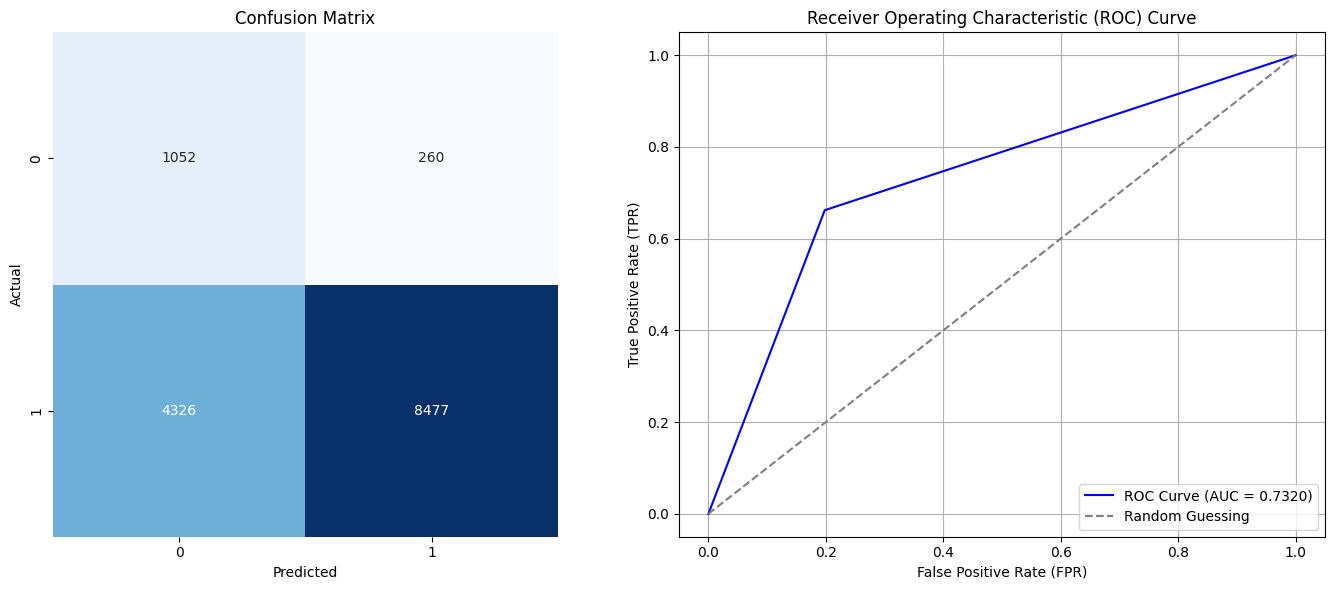

In [82]:
evaluation(y_test,y_pred)

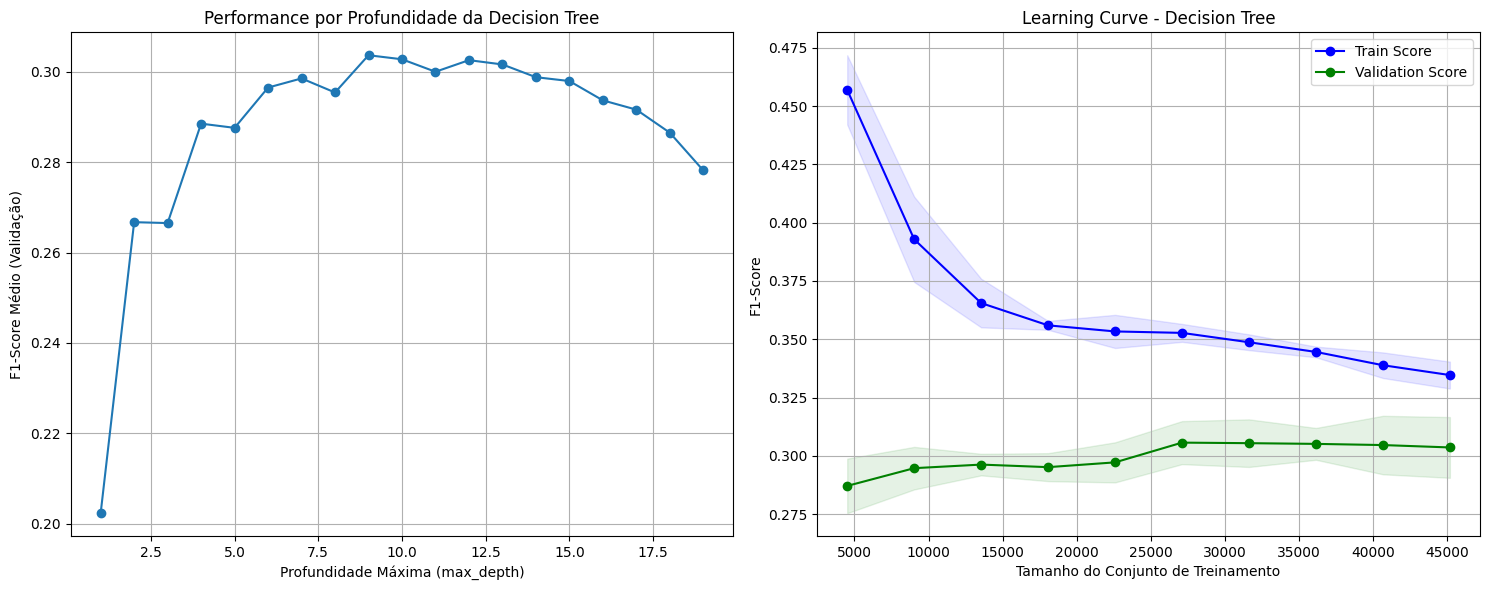

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  

# Gráfico da performance por profundidade
axs[0].plot(max_depth_values, mean_f1_scores, marker='o')
axs[0].set_xlabel("Profundidade Máxima (max_depth)")
axs[0].set_ylabel("F1-Score Médio (Validação)")
axs[0].set_title("Performance por Profundidade da Decision Tree")
axs[0].grid()

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train, cv=kf, scoring=f1_label_0, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)

# Calcular a média e desvio padrão para cada tamanho de treino
train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_std = val_scores.std(axis=1)

# Learning curve
axs[1].plot(train_sizes, train_scores_mean, label='Train Score', color='blue', marker='o')
axs[1].plot(train_sizes, val_scores_mean, label='Validation Score', color='green', marker='o')

# Áreas de desvio padrão
axs[1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
axs[1].fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='green')

# Labels
axs[1].set_xlabel("Tamanho do Conjunto de Treinamento")
axs[1].set_ylabel("F1-Score")
axs[1].set_title("Learning Curve - Decision Tree")
axs[1].legend(loc='best')
axs[1].grid(True)

plt.tight_layout() 
plt.show()

Stratified

In [84]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

param_grid = {'max_depth': range(1, 20)}

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=skf, scoring=f1_label_0)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)
mean_f1_scores = grid_search.cv_results_['mean_test_score']
max_depth_values = grid_search.cv_results_['param_max_depth'].data

print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 11}


F1 score:  0.30752419606618797
Precision:  0.19230769230769232
Recall:  0.7671339563862928
Accuracy:  0.685724406659582


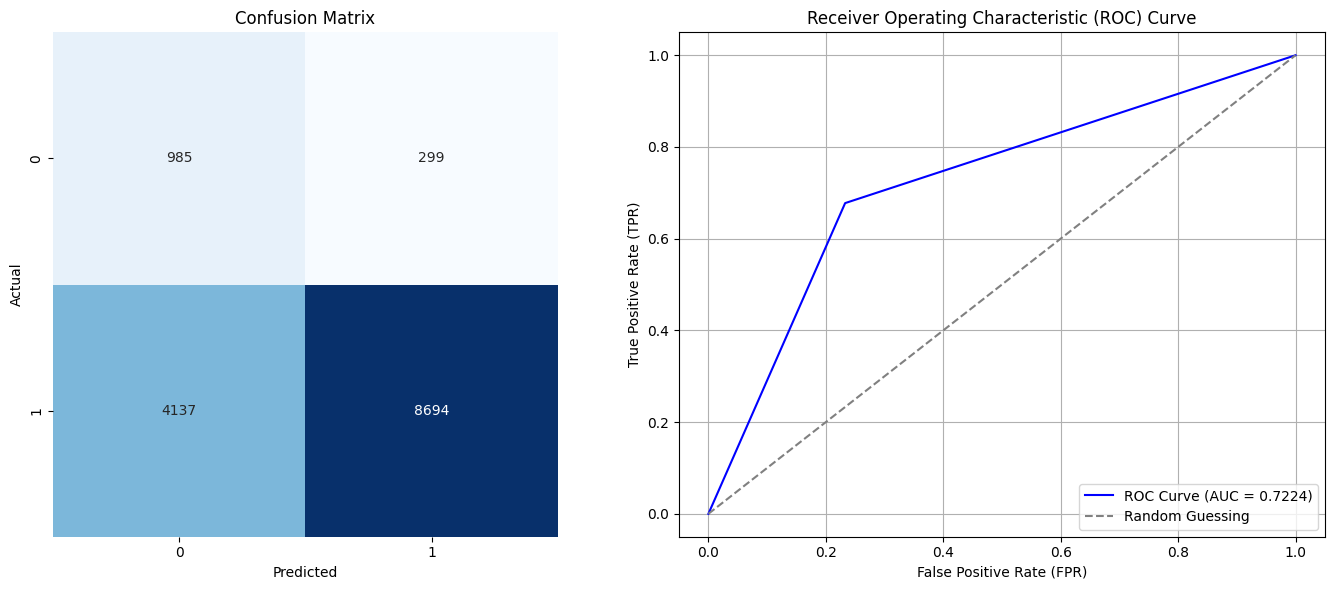

In [85]:
evaluation(y_test,y_pred)

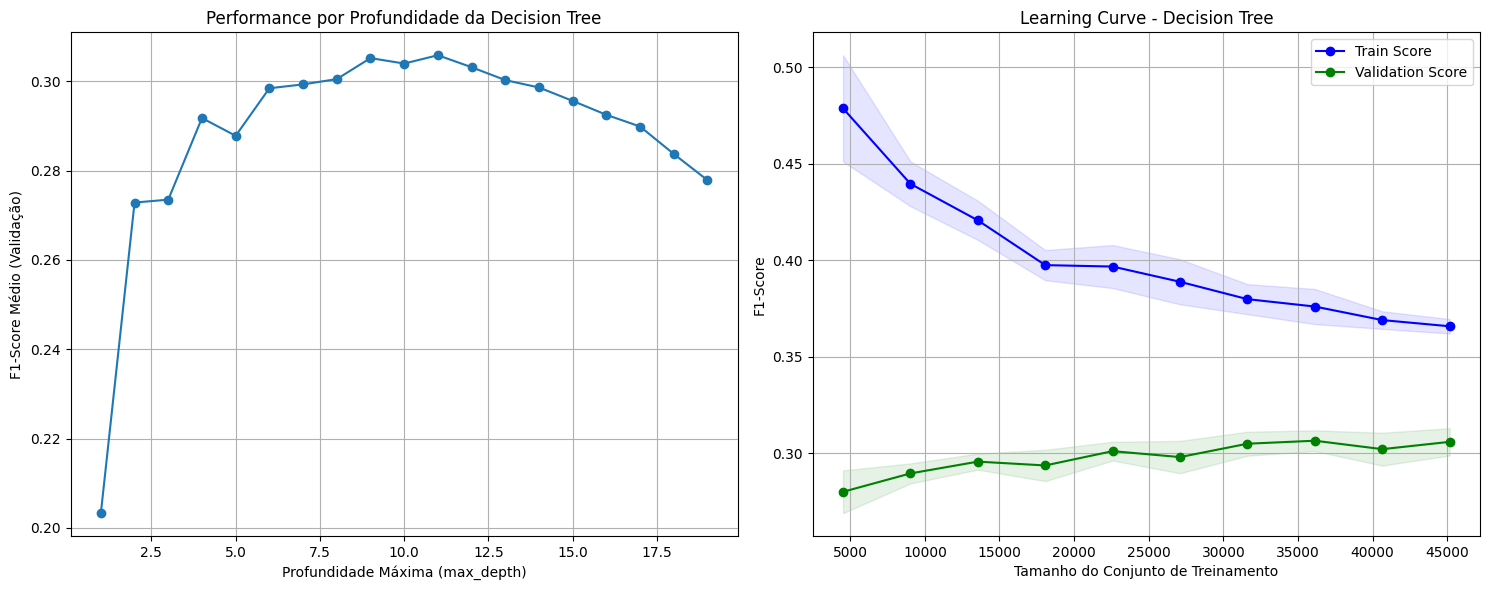

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 

# Gráfico da performance por profundidade
axs[0].plot(max_depth_values, mean_f1_scores, marker='o')
axs[0].set_xlabel("Profundidade Máxima (max_depth)")
axs[0].set_ylabel("F1-Score Médio (Validação)")
axs[0].set_title("Performance por Profundidade da Decision Tree")
axs[0].grid()

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train, cv=skf, scoring=f1_label_0, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)

# Calcular a média e desvio padrão para cada tamanho de treino
train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_std = val_scores.std(axis=1)

# Learning curve
axs[1].plot(train_sizes, train_scores_mean, label='Train Score', color='blue', marker='o')
axs[1].plot(train_sizes, val_scores_mean, label='Validation Score', color='green', marker='o')

# Áreas de desvio padrão
axs[1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
axs[1].fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='green')

# Labels
axs[1].set_xlabel("Tamanho do Conjunto de Treinamento")
axs[1].set_ylabel("F1-Score")
axs[1].set_title("Learning Curve - Decision Tree")
axs[1].legend(loc='best')
axs[1].grid(True)

plt.tight_layout() 
plt.show()

ANALISE: 

Inicialmente tentamos a decision tree com valores parametros so que os valores do f1 davam sempre muito muito baixos.

Entao pusemos o parametro class_weight='balanced' no classifier para ver se os resultados melhoravam e notou se uma diferença gigante pois antes o AUC tava muito perto do random e agora está mais ou menos a 0.72. Claro que se perdeu bastante accuracy mas aqui como o nosso foco é a classe minoritária, notou se uma evolucao muito boa na avaliacao desta.

De forma a arranjar um valor ideal para o tamanho da arvore pusemos lado a lado um grafico a mostrar o f1 para diferentes valores de profundidade e a learning curve para verificar a perfomance do modelo e ver se nao haver under ou overfitting. Para ambos os casos, a altura ideal da arvore foi =9 pois da nos um modelo com maior f1 e parece estar a generar razoavelmente bem.

Novamente, nao se notou grande diferença entre o estratificado e o sem ser estratificado.

Overall, este modelo é decente apesar de se ter de sacrificar bastante a accuracy para ele funcionar melhor na classificaçao da classe minoritária. 

### Tree Ensembles


In [87]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

dfen = dfc

X = dfen.drop('health_ins', axis=1)  
y = dfen['health_ins'] 

#### RandomForest

Non-stratified

In [88]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kf, scoring=f1_label_0)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 10, 'n_estimators': 500}


F1 score:  0.33191489361702126
Precision:  0.2113380575239683
Recall:  0.7728658536585366
Accuracy:  0.7108041091037903


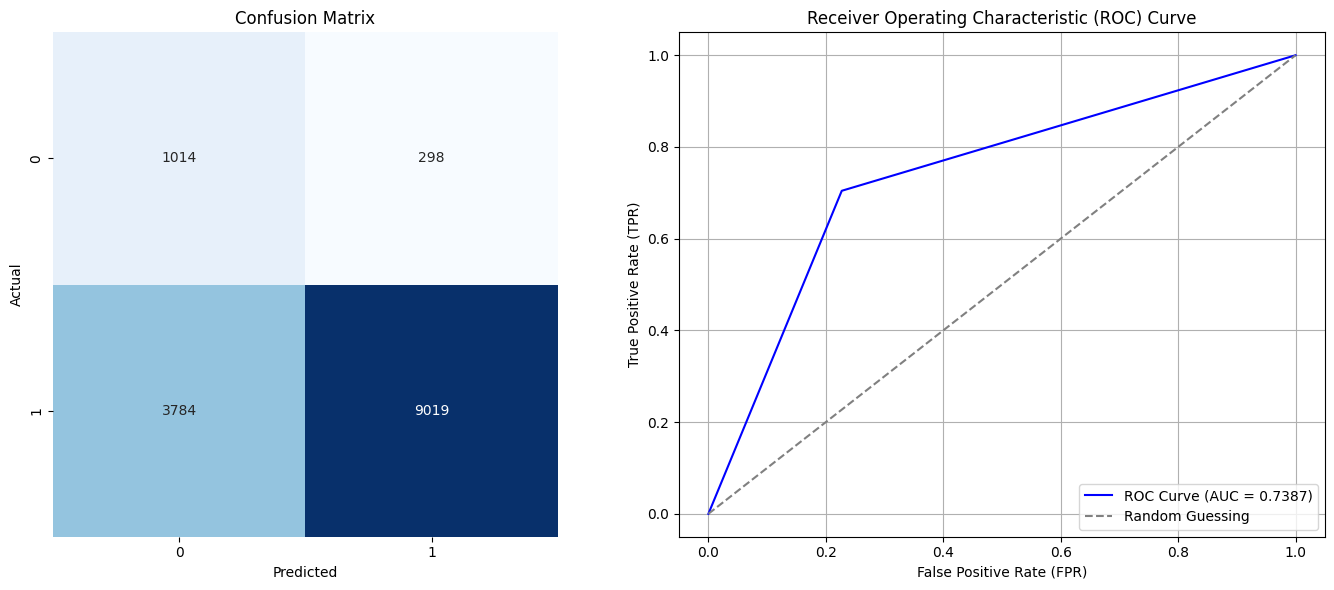

In [89]:
evaluation(y_test, y_pred)

Stratified

We decided to just tune the number of estimators to speed up the process, since the max depth of 9/10 has been shown to be the best for the decision trees and the non stratified Random Forest model.

In [90]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=10, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=skf, scoring=f1_label_0)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'n_estimators': 500}


F1 score:  0.3266543189089072
Precision:  0.2083780880773362
Recall:  0.7554517133956387
Accuracy:  0.7166843783209351


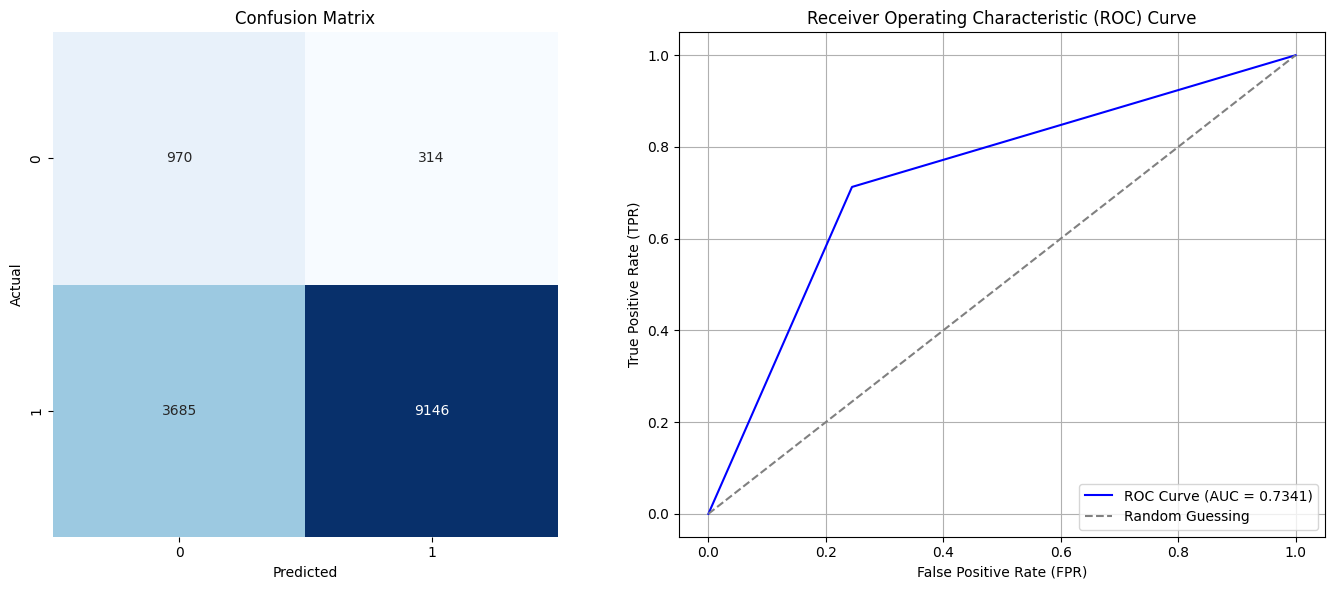

In [91]:
evaluation(y_test, y_pred)

#### XGBoost

Non-stratified

In [92]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30]
}

negative_samples = sum(y_train == 0)
positive_samples = sum(y_train == 1)
scale_pos_weight = negative_samples / positive_samples

xg = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=xg, param_grid=param_grid, cv=kf, scoring=f1_label_0)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': None, 'n_estimators': 100}


F1 score:  0.3323392975480451
Precision:  0.21232006773920406
Recall:  0.7644817073170732
Accuracy:  0.7144881331916401


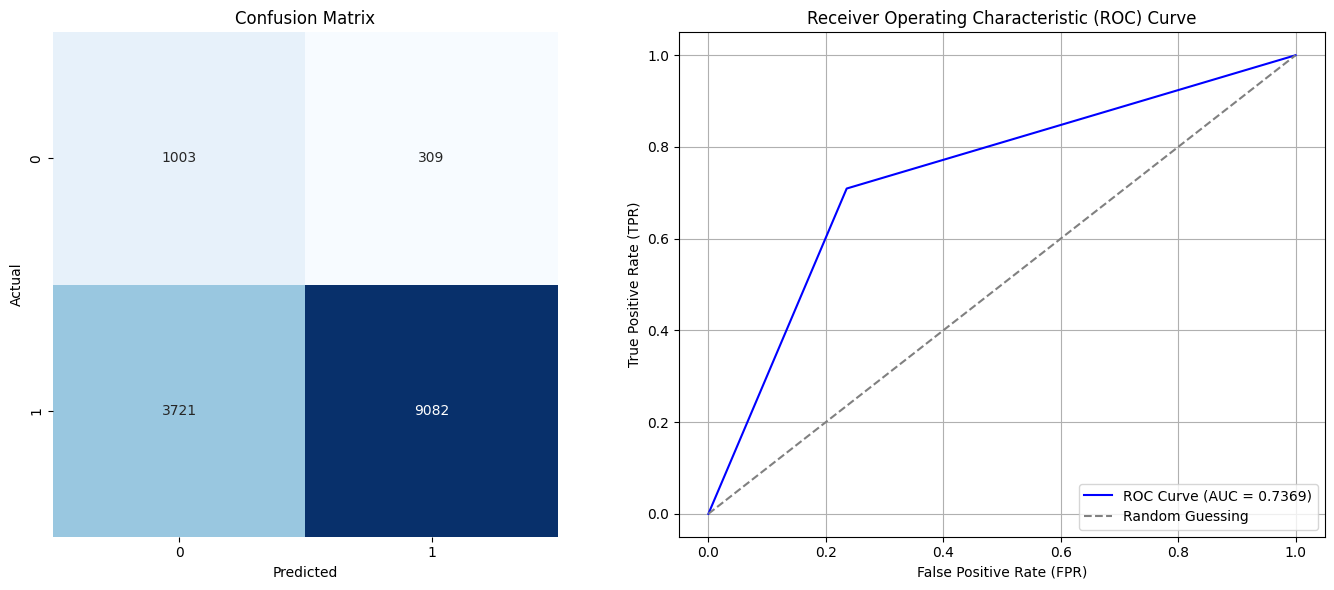

In [93]:
evaluation(y_test, y_pred)

Stratified

In [94]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500]
}

negative_samples = sum(y_train == 0)
positive_samples = sum(y_train == 1)
scale_pos_weight = negative_samples / positive_samples

xg = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=xg, param_grid=param_grid, cv=skf, scoring=f1_label_0)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'n_estimators': 100}


F1 score:  0.32835319791841533
Precision:  0.2092873956772951
Recall:  0.7616822429906542
Accuracy:  0.7165426850867871


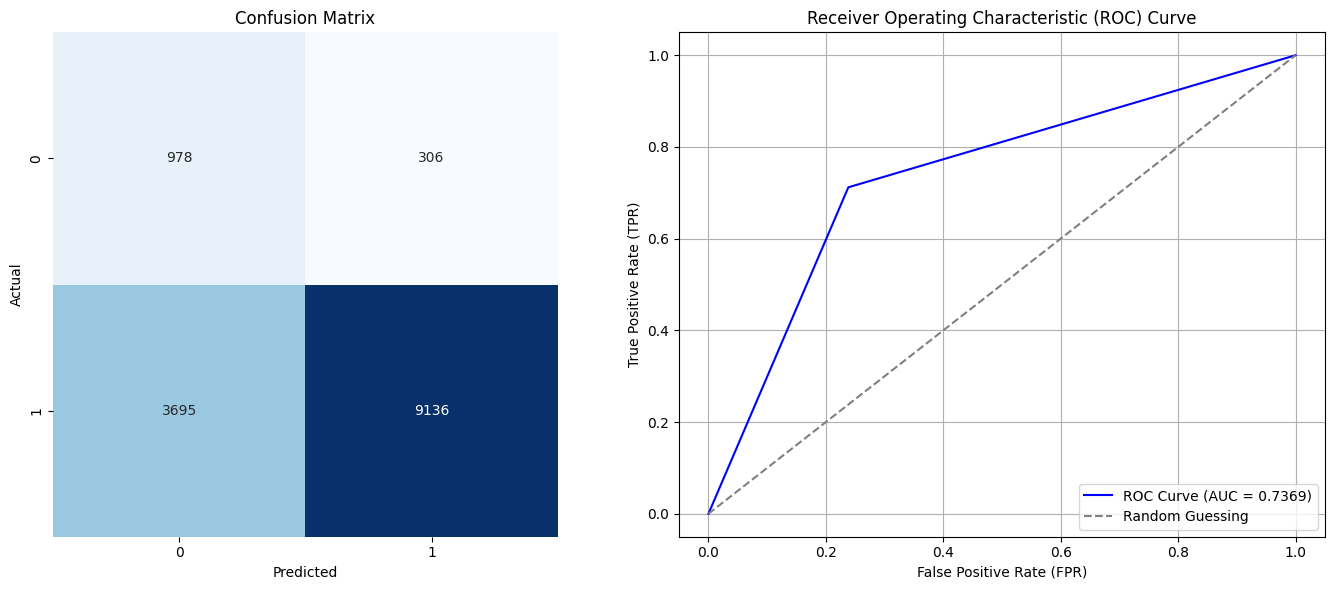

In [95]:
evaluation(y_test, y_pred)

### SVM

In [98]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

# standardizing
dfsvm = dfknn

# dividing features and target
X = dfsvm.drop('health_ins', axis=1)
y = dfsvm['health_ins']

# Stratified (balanced dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameters for RandomizedSearchCV
param_dist = {
    'C': np.logspace(-3, 3, 10), 
}

# RandomizedSearchCV configuration
svm = SVC(probability=True, random_state=42)
random_search = RandomizedSearchCV(
    svm,
    param_distributions=param_dist, 
    scoring=f1_label_0,
    cv=5,  # cross validation
    random_state=42,
    n_jobs=-1  
)

# model training using the best hyperparameters
random_search.fit(X_train, y_train)

# results of the best model
best_svm = random_search.best_estimator_
print("Melhores hiperparâmetros encontrados:", random_search.best_params_)

# predictions and evaluation of test (Balanced Dataset)
y_pred = best_svm.predict(X_test)
print("\nResultados no Balanced Dataset:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


KeyboardInterrupt: 

In [ ]:

# Non stratified (non-balanced dataset)
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X, y, test_size=0.2, random_state=42)

# Adjusting the model in Non-Balanced Dataset
random_search.fit(X_train_nb, y_train_nb)
best_svm_nb = random_search.best_estimator_

# predictions and evaluation of test (Non-Balanced Dataset)
y_pred_nb = best_svm_nb.predict(X_test_nb)
print("\nResultados no Non-Balanced Dataset:")
print(confusion_matrix(y_test_nb, y_pred_nb))
print(classification_report(y_test_nb, y_pred_nb))

# ROC curve for Balanced Dataset
RocCurveDisplay.from_estimator(best_svm, X_test, y_test)
plt.title('ROC Curve - Balanced Dataset')
plt.show()

# ROC curve for Non-Balanced Dataset
RocCurveDisplay.from_estimator(best_svm_nb, X_test_nb, y_test_nb)
plt.title('ROC Curve - Non-Balanced Dataset')
plt.show()

